In [1]:
%%capture --no-stderr
%pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core

Get the Keys from the collab notebook

In [3]:
import getpass
import os

# Load environment variables from a .env file
from google.colab import userdata
os.environ["OPENAI_API_KEY"]=userdata.get('OPENAI_API_KEY')
os.environ["TAVILY_API_KEY"]=userdata.get('TAVILY_API_KEY')

## Langsmith tracking
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_API_KEY"]=userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_PROJECT"]="Binary Search Trees"

In [4]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

In [ ]:
%pip install faiss-cpu  langchain-openai langchain-community

In [6]:
%pip install -q pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.5/294.5 kB 11.3 MB/s eta 0:00:00


In [10]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain.embeddings.openai import OpenAIEmbeddings
indexName="BinarySearchTrees"

Use this code only when generating the embeddings the first time. If you have the data base folder execute the next cell directly

In [10]:
loader = PyPDFLoader("data/BinarySearchTrees.pdf")
documents=loader.load()
text_splitter=RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=100)
final_documents=text_splitter.split_documents(documents)
embeddings=OpenAIEmbeddings()
vecStore=FAISS.from_documents(final_documents,embeddings)
# Save the vector DB to your local
db =vecStore.save_local(folder_path="Database", index_name=indexName)

<ipython-input-10-d842f5c8a4c5>:11: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings=OpenAIEmbeddings()


In [12]:
db

In [11]:
db=FAISS.load_local(folder_path="Database", index_name=indexName, embeddings=OpenAIEmbeddings(),allow_dangerous_deserialization=True)

<ipython-input-11-cc81e16259f7>:1: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  db=FAISS.load_local(folder_path="Database", index_name=indexName, embeddings=OpenAIEmbeddings(),allow_dangerous_deserialization=True)


In [13]:
from langchain.tools.retriever import create_retriever_tool
retriever=db.as_retriever()
retriever_tool=create_retriever_tool(retriever,"BinarySearchTreesBook", "This contains information about binary search tree concepts. Use this to create a study plan and create mock tests when requested by the user.")

In [24]:
from typing import Annotated
from typing_extensions import TypedDict

## Langgraph Application
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list,add_messages]

In [25]:
from langchain_openai import ChatOpenAI
llm=ChatOpenAI(model_name="gpt-4o")
llm

ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x7dfd38539870>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x7dfd383e8fa0>, root_client=<openai.OpenAI object at 0x7dfd38522e30>, root_async_client=<openai.AsyncOpenAI object at 0x7dfd3853b640>, model_name='gpt-4o', model_kwargs={}, openai_api_key=SecretStr('**********'))

In [26]:
tools=[retriever_tool]

In [27]:
llm_with_tools=llm.bind_tools(tools=tools)

In [28]:
def bstGuide(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [32]:
from langgraph.graph import StateGraph,START,END
workflow= StateGraph(State)


In [33]:
from langgraph.prebuilt import ToolNode,tools_condition

workflow.add_node("BST", bstGuide)
tool_node = ToolNode(tools=tools)
workflow.add_node("tools", tool_node)
workflow.add_conditional_edges(
    "BST",
    tools_condition,
)
workflow.add_edge("tools", "BST")
workflow.add_edge(START,"BST")

In [35]:
graph=workflow.compile()

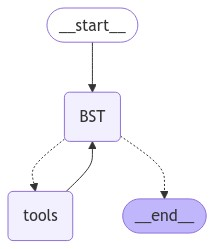

In [36]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [37]:
user_input="I want to learn about binary search trees. Can you give me a study plan based on the topics to study along with time required"

events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

I want to learn about binary search trees. Can you give me a study plan based on the topics to study along with time required
================================== Ai Message ==================================
Tool Calls:
  BinarySearchTreesBook (call_Eqh0t9JEOuikqXRpjQskar5X)
 Call ID: call_Eqh0t9JEOuikqXRpjQskar5X
  Args:
    query: study plan
================================= Tool Message =================================
Name: BinarySearchTreesBook

Problems for Chapter 11 309 
been inserted. Your mission is to prove an O.lg n=  lg lg n/ upper bound on E ŒM �, 
the expected value of M  . 
a. Argue that the probability Q k that exactly k keys hash to a particular slot is 
given by 
Q k D Î 1 
n Ï k Î 
1  1 
n Ï nk  
n 
k ! 
: 
b. Let P k be the probability that M  D k, that is, the probability that the slot 
containing the most keys contains k keys. Show that P k හ nQ  k .

you know the search frequenc

In [38]:
user_input="I want to learn about binary search trees. I have 8 hours allocated for this preparation. I can give 2 hours per day. Can you give me a study plan based on the topics to study in 8 hours"

events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

I want to learn about binary search trees. I have 8 hours allocated for this preparation. I can give 2 hours per day. Can you give me a study plan based on the topics to study in 8 hours
================================== Ai Message ==================================
Tool Calls:
  BinarySearchTreesBook (call_hwAePGipPxKGU7q1YEPV1FkM)
 Call ID: call_hwAePGipPxKGU7q1YEPV1FkM
  Args:
    query: topics to study for 8 hours
================================= Tool Message =================================
Name: BinarySearchTreesBook

Problems for Chapter 11 309 
been inserted. Your mission is to prove an O.lg n=  lg lg n/ upper bound on E ŒM �, 
the expected value of M  . 
a. Argue that the probability Q k that exactly k keys hash to a particular slot is 
given by 
Q k D Î 1 
n Ï k Î 
1  1 
n Ï nk  
n 
k ! 
: 
b. Let P k be the probability that M  D k, that is, the probability that the slot 
containing the mo

In [39]:
user_input="Thanks! Can you create a cheatsheet for traversal mechanisms"

events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Thanks! Can you create a cheatsheet for traversal mechanisms
================================== Ai Message ==================================
Tool Calls:
  BinarySearchTreesBook (call_zdEPjtTQv69DKKJqYHNNfZly)
 Call ID: call_zdEPjtTQv69DKKJqYHNNfZly
  Args:
    query: preorder traversal
  BinarySearchTreesBook (call_lu26akqN15Ccw3tUldwsYm0e)
 Call ID: call_lu26akqN15Ccw3tUldwsYm0e
  Args:
    query: inorder traversal
  BinarySearchTreesBook (call_rNodo7qpj4Flmt6K5KkrgTk5)
 Call ID: call_rNodo7qpj4Flmt6K5KkrgTk5
  Args:
    query: postorder traversal
  BinarySearchTreesBook (call_ewjmJHdPNuUvrQKczJqZMiG5)
 Call ID: call_ewjmJHdPNuUvrQKczJqZMiG5
  Args:
    query: level order traversal
================================= Tool Message =================================
Name: BinarySearchTreesBook

binary search tree in sorted order by a simple recu rsive algorithm, called an inorder  
tree  walk , given by the 